In [1]:
import csv
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
with open("data/warszawa_addresses.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
sample = pd.DataFrame(lst).set_index('Id')

Filling Neighbourhoods
--------
If neighbourhood is missing, replace missing with name of borough 

In [3]:
sample['Neighbourhood_filled'] = [b if n=='.' else n for b,n in zip(sample['Borough'],sample['Neighbourhood'])]

Converting dates
-----------
Converting dates in dataframe from string representation to datetime

In [4]:
def convert_to_date(date_str):
    if not date_str == '.':
        months = {'Stycznia':1,'Lutego':2,'Marca':3,'Kwietnia':4,'Maja':5,'Czerwca':6,
                  'Lipca':7,'Sierpnia':8,'Września':9,'Października':10,'Listopada':11, 'Grudnia':12}    
        x = date_str.split(' ')
        return pd.datetime(int(x[2]),months[x[1]],int(x[0]))
    return None

def days_after_publication(date):
    def f(item):
        if item == 'ponad 14 dni temu':
            return 15
        else:
            x = item.split('.')
            date_temp = pd.datetime(int(x[2]),int(x[1]),int(x[0]))
            return (date-date_temp).days+1
    return f
sample['available'] = sample['available'].apply(convert_to_date)
converter = days_after_publication(pd.datetime(2018,9,9))
sample['publicated'] = sample['publicated'].apply(converter)
sample['updated'] = sample['updated'].apply(converter)

Data inputation
-----------
Adding a missing category to categorial observations
 

In [5]:
sample['building_material']     = ['missing' if i=='.' else i for i in sample['building_material']]
sample['building_type']         = ['missing' if i=='.' else i for i in sample['building_type']]
sample['construction_status']   = ['missing' if i=='.' else i for i in sample['construction_status']]
sample['heating']               = ['missing' if i=='.' else i for i in sample['heating']]
sample['market']                = ['missing' if i=='.' else i for i in sample['market']]
sample['ownership']             = ['missing' if i=='.' else i for i in sample['ownership']]
sample['window']                = ['missing' if i=='.' else i for i in sample['window']]

Extracting floor numbers
-----------------
Converting string representation of floor numbers into integers. The floor numbers are hold as string, for example  4 (z 6). We need to tokenize the string and save it separately as floor of flat and number of floors in building.

In [6]:
mapping_floornum = dict()
mapping_blockfnum = dict()

for orig in list(sample['floor_num'].unique()):
    temp = orig.replace('parter','groundfloor')
    temp = temp.replace('suterena','basement')
    temp = temp.replace('poddasze','attic')
    temp = temp.replace('> 10','gt10')    
    if 'z' in orig:
        mapping_floornum[orig] = temp.split('(z')[0].strip()
        mapping_blockfnum[orig] = temp.split('(z')[1][1:-1]        
    else:
        mapping_floornum[orig] = temp
        mapping_blockfnum[orig] = 'missing'
        
sample['appartment_floor_no'] =  sample['floor_num'].map(mapping_floornum) 
sample['building_floor_no']   =  sample['floor_num'].map(mapping_blockfnum)
sample.drop(['floor_num'],axis=1,inplace=True)

Calculating prizes
----------

In [7]:
mapping = {'PLN': 1, 'EUR': 4.2}
sample['price'] = [ float(p) *mapping[c] for p,c in zip(sample['price'],sample['price_currency']) ] 
sample['surface'] = sample['surface'].apply(lambda x: round(float(x)))
sample['price_per_sqm'] = [ p / s  for p,s in zip(sample['price'],sample['surface']) ] 

We check the distribution of prices. We see that some apartments have extremely high or low price. We delete them from as sample considering those observation as erroneous

In [8]:
sample['price_per_sqm'].describe()

count     11508.000000
mean       9652.023960
std        3638.247543
min           1.000000
25%        7660.861359
50%        9000.000000
75%       10844.827586
max      114224.785714
Name: price_per_sqm, dtype: float64

In [9]:
sample[(sample['price_per_sqm'] <  3000)][['Borough','price','surface','price_per_sqm']]

,Borough,price,surface,price_per_sqm
Id,,,,
55257536,białołęka,469000.0,160,2931.250000
51801228,wesoła,380270.0,132,2880.833333
54770944,praga południe,400000.0,200,2000.000000
55382588,mokotów,610500.0,811,752.774353
55622628,mokotów,5200.0,100,52.000000
55627928,śródmieście,69000.0,59,1169.491525
54427100,ochota,356000.0,135,2637.037037
55619764,mokotów,368554.0,368554,1.000000


In [10]:
sample[(sample['price_per_sqm'] > 50000)][['Borough','price','surface','price_per_sqm']]

,Borough,price,surface,price_per_sqm
Id,,,,
55047352,mokotów,4891095.0,48,101897.812500
54843616,mokotów,1599147.0,14,114224.785714


In [11]:
sample = sample[(sample['price_per_sqm'] > 3000) & (sample['price_per_sqm'] < 50000)]
sample['price_per_sqm'].describe()

count    11497.000000
mean      9641.118966
std       3392.277791
min       3061.538462
25%       7661.538462
50%       9000.000000
75%      10844.827586
max      47941.285417
Name: price_per_sqm, dtype: float64

In [12]:
sample['surface'].describe()

count    11497.000000
mean        66.041402
std         32.389892
min         16.000000
25%         46.000000
50%         59.000000
75%         78.000000
max        480.000000
Name: surface, dtype: float64

In [13]:
print(sample[sample['surface'] > 400])

              Borough      City         Neighbourhood Street available  \
Id                                                                       
54555896      mokotów  warszawa                     .      .       NaT   
53357908  śródmieście  warszawa  śródmieście północne  złota       NaT   

         building_material building_type construction_status       district  \
Id                                                                            
54555896           missing     apartment             missing  górny mokotów   
53357908             other     apartment             missing    śródmieście   

         equipment_dishwasher      ...      security_roller_shutters  \
Id                                 ...                                 
54555896                    0      ...                             0   
53357908                    0      ...                             0   

         security_security surface updated     window year_of_construction  \
Id                 

Removing duplicates
-------------------

We identify duplicates by website link. Usually same offer is upload few times. We can recognize them by link (the beginning of link is the same, but endings have got different number sequences, see example below. 

In [14]:
print(sample.loc[[str(54816988)]]['link'][0])
print(sample.loc[[str(54816996)]]['link'][0])

https://www.otodom.pl/oferta/0-prowizji-doskonala-lokalizacja-wysoki-standard-ID3I0oY.html
https://www.otodom.pl/oferta/0-prowizji-doskonala-lokalizacja-wysoki-standard-ID3I0p6.html


In [15]:
temp = sample[['link']].copy()
temp['link'] = [x[:-13] for x in temp['link']]
duplicates = temp.duplicated()

i = 0
delete_from_sample = []
for item in duplicates.iteritems():
    i = i + item[1]
    delete_from_sample.append(not item[1])
print('Number of duplicates identified by link',i)
sample = sample[delete_from_sample]
print('After removing duplicates',sample.shape[0])

Number of duplicates identified by link 2461
After removing duplicates 9036


We also recognize duplicates by similarity in flat description.
If two flats have the same:
* price
* surface
* number of rooms
* year of construction
* building type
* number of building floors
and lays in the same borough, we recognize those flats as duplicates.

In [16]:
temp = sample[['Borough','building_floor_no','price','surface','rooms','building_type','year_of_construction']].copy()
duplicates = temp.duplicated(keep=False)

i = 0
delete_from_sample = []
for item in duplicates.iteritems():
    i = i + item[1]
    delete_from_sample.append(not item[1])
print('Number of duplicates identified by characteristics of flat',i)
sample = sample[delete_from_sample]
print('After removing duplicates',sample.shape[0])

Number of duplicates identified by characteristics of flat 1163
After removing duplicates 7873


Correcting the rent
--------

We transform rent from string in form 'xxx zl'  to float xxx

In [17]:
sample['rent'] = [ float(x[:-3].replace(' ','').replace(',','.')) if x != '.' else np.nan for x in sample['rent']]

Age of apartment
----------

Basing on the year of construction we calculate the age of flat.

Firstly we identify erroneous data.

In [18]:
print(sorted(list(sample['year_of_construction'].unique())))

['.', '1', '1061', '1700', '1730', '1782', '1784', '1790', '1800', '1815', '1823', '1826', '1830', '1832', '1853', '1870', '1877', '1882', '1888', '1890', '1893', '1895', '1897', '1900', '1902', '1904', '1905', '1906', '1907', '1910', '1911', '1912', '1913', '1914', '1915', '1918', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '20', '2000', '2001', '20018', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'

In [19]:
mapping ={'70':'1970','66':'1966','1':'.','2204':'2024','20':'2020','74':'1974','1061':'1961','20018':'2018','218':'2018'}
sample['year_of_construction'] = [mapping[y] if y in mapping.keys() else y for y in sample['year_of_construction'] ]
print(sorted(list(sample['year_of_construction'].unique())))

sample['age'] = sample['year_of_construction'].apply(lambda x: max(min(2019-int(x),150),0) if x != '.' else np.nan) 

['.', '1700', '1730', '1782', '1784', '1790', '1800', '1815', '1823', '1826', '1830', '1832', '1853', '1870', '1877', '1882', '1888', '1890', '1893', '1895', '1897', '1900', '1902', '1904', '1905', '1906', '1907', '1910', '1911', '1912', '1913', '1914', '1915', '1918', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2

Filling missing age
----------

The number of missing for age of flat is quite high.

We assume that age missing are MAR type (Missing at random). It means thatthe propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data. We assume that age of flat will be highly dependent on borough, type of flat or technology it was build (type of material). We investigate if distribution of age is unimodal for borough, flat type and materials or for combination of those three. Then basing on our analysis we will fill age using mean, median or randomly picked number.

We will fill the missing according to following algorithm
* Missings for flats from primary market are replaced with 1.0
* Replace the missing by mean, media or random choice, after identifying the proper subpopulation.

We will check the quality of our imputation by analyzing distribution of age before and after filling the missings. To many outliers or to large concentration indicates poor quality of inputation 

In [20]:
print('Number of missing age',sample['age'].isna().sum())
print('Number of missing age as percentage of sample',round(100*sample['age'].isna().sum()/len(sample['age'])),'%')

Number of missing age 1353
Number of missing age as percentage of sample 17.0 %


Missing age for primery market offers are filled with *1.0* 

In [21]:
sample['age'] = [1.0 if math.isnan(a) and m == 'primary' else a for a,m in zip(sample['age'],sample['market'])]

print('Number of missing age',sample['age'].isna().sum())
print('Number of missing age as percentage of sample',round(100*sample['age'].isna().sum()/len(sample['age'])),'%')

Number of missing age 616
Number of missing age as percentage of sample 8.0 %


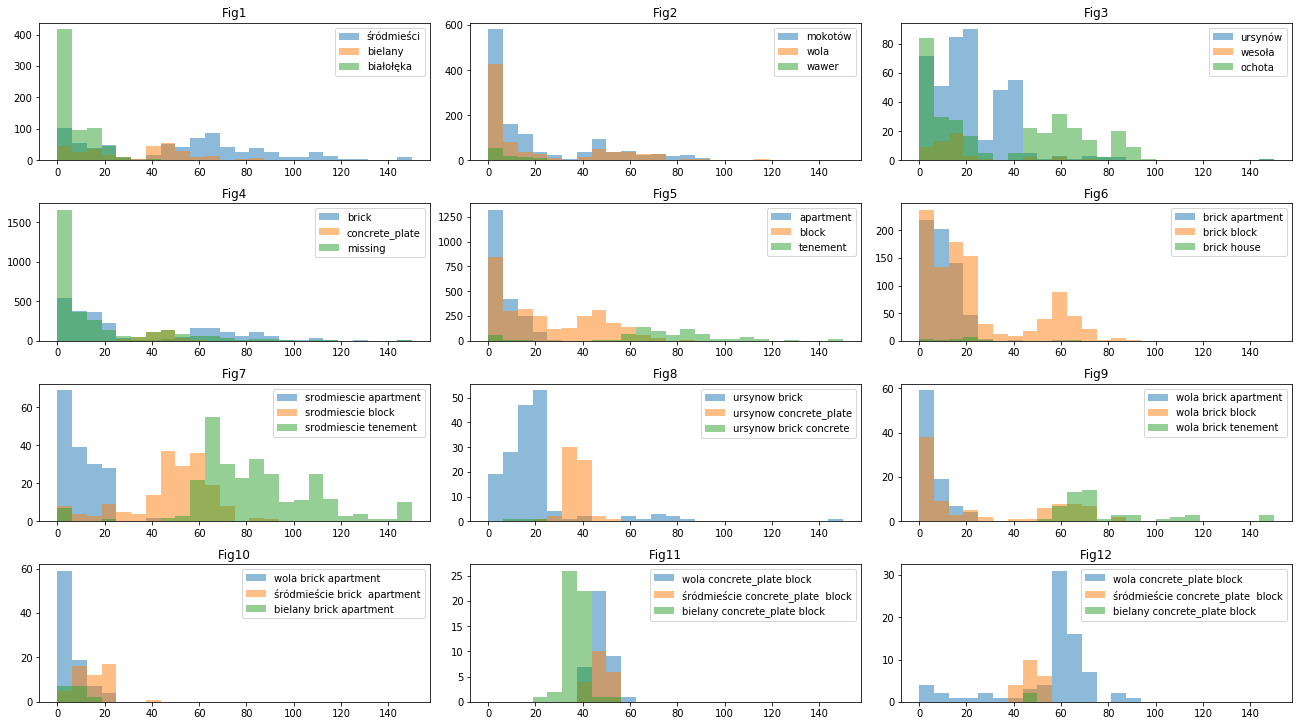

In [22]:
bins = np.linspace(min(sample['age']), max(sample['age']), 25)

f, ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33), (ax41, ax42, ax43)) = plt.subplots(4,3,figsize=(18,10))

ax11.hist(sample[sample['Borough']=='śródmieście']['age'].dropna(), bins, alpha=0.5, label='śródmieści')
ax11.hist(sample[sample['Borough']=='bielany']['age'].dropna(), bins, alpha=0.5, label='bielany')
ax11.hist(sample[sample['Borough']=='białołęka']['age'].dropna(), bins, alpha=0.5, label='białołęka')
ax11.legend(loc='upper right')
ax11.set_title('Fig1')

ax12.hist(sample[sample['Borough']=='mokotów']['age'].dropna(), bins, alpha=0.5, label='mokotów')
ax12.hist(sample[sample['Borough']=='wola']['age'].dropna(), bins, alpha=0.5, label='wola')
ax12.hist(sample[sample['Borough']=='wawer']['age'].dropna(), bins, alpha=0.5, label='wawer')
ax12.legend(loc='upper right')
ax12.set_title('Fig2')

ax13.hist(sample[sample['Borough']=='ursynów']['age'].dropna(), bins, alpha=0.5, label='ursynów')
ax13.hist(sample[sample['Borough']=='wesoła']['age'].dropna(), bins, alpha=0.5, label='wesoła')
ax13.hist(sample[sample['Borough']=='ochota']['age'].dropna(), bins, alpha=0.5, label='ochota')
ax13.legend(loc='upper right')
ax13.set_title('Fig3')

ax21.hist(sample[sample['building_material']=='brick']['age'].dropna(), bins, alpha=0.5, label='brick')
ax21.hist(sample[sample['building_material']=='concrete_plate']['age'].dropna(), bins, alpha=0.5, label='concrete_plate')
ax21.hist(sample[sample['building_material']=='missing']['age'].dropna(), bins, alpha=0.5, label='missing')
ax21.legend(loc='upper right')
ax21.set_title('Fig4')

ax22.hist(sample[sample['building_type']=='apartment']['age'].dropna(), bins, alpha=0.5, label='apartment')
ax22.hist(sample[sample['building_type']=='block']['age'].dropna(), bins, alpha=0.5, label='block')
ax22.hist(sample[sample['building_type']=='tenement']['age'].dropna(), bins, alpha=0.5, label='tenement')
ax22.legend(loc='upper right')
ax22.set_title('Fig5')

ax23.hist(sample[(sample['building_type']=='apartment') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='brick apartment')
ax23.hist(sample[(sample['building_type']=='block')  & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='brick block')
ax23.hist(sample[(sample['building_type']=='house')  & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='brick house')
ax23.legend(loc='upper right')
ax23.set_title('Fig6')

ax31.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='apartment')]['age'].dropna(), bins, alpha=0.5, label='srodmiescie apartment')
ax31.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='block')]['age'].dropna(), bins, alpha=0.5, label='srodmiescie block')
ax31.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='tenement')]['age'].dropna(), bins, alpha=0.5, label='srodmiescie tenement')
ax31.legend(loc='upper right')
ax31.set_title('Fig7')

ax32.hist(sample[(sample['Borough']=='ursynów') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='ursynow brick')
ax32.hist(sample[(sample['Borough']=='ursynów') & (sample['building_material']=='concrete_plate')]['age'].dropna(), bins, alpha=0.5, label='ursynow concrete_plate')
ax32.hist(sample[(sample['Borough']=='ursynów') & (sample['building_material']=='concrete')]['age'].dropna(), bins, alpha=0.5, label='ursynow brick concrete')
ax32.legend(loc='upper right')
ax32.set_title('Fig8')

ax33.hist(sample[(sample['Borough']=='wola') & (sample['building_type']=='apartment') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola brick apartment')
ax33.hist(sample[(sample['Borough']=='wola') & (sample['building_type']=='block') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola brick block')
ax33.hist(sample[(sample['Borough']=='wola') & (sample['building_type']=='tenement') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola brick tenement')
ax33.legend(loc='upper right')
ax33.set_title('Fig9')

ax41.hist(sample[(sample['Borough']=='wola') & (sample['building_type']=='apartment') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola brick apartment')
ax41.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='apartment') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='śródmieście brick  apartment')
ax41.hist(sample[(sample['Borough']=='bielany') & (sample['building_type']=='apartment') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='bielany brick apartment')
ax41.legend(loc='upper right')
ax41.set_title('Fig10')

ax42.hist(sample[(sample['Borough']=='wola') & (sample['building_type']=='block') & (sample['building_material']=='concrete_plate')]['age'].dropna(), bins, alpha=0.5, label='wola concrete_plate block')
ax42.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='block') & (sample['building_material']=='concrete_plate')]['age'].dropna(), bins, alpha=0.5, label='śródmieście concrete_plate  block')
ax42.hist(sample[(sample['Borough']=='ursynów') & (sample['building_type']=='block') & (sample['building_material']=='concrete_plate')]['age'].dropna(), bins, alpha=0.5, label='bielany concrete_plate block')
ax42.legend(loc='upper right')
ax42.set_title('Fig11')

ax43.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='block') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola concrete_plate block')
ax43.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='block') & (sample['building_material']=='concrete_plate')]['age'].dropna(), bins, alpha=0.5, label='śródmieście concrete_plate  block')
ax43.hist(sample[(sample['Borough']=='śródmieście') & (sample['building_type']=='block') & (sample['building_material']=='concrete')]['age'].dropna(), bins, alpha=0.5, label='bielany concrete_plate block')
ax43.legend(loc='upper right')
ax43.set_title('Fig12')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

We see that using all features: borough, material and type of building gives most unimodal distributions (compare Fig10-Fig12)

In [23]:
# Creating a dict with key (borough_material_type) and mean/median of age as value  that will be used to replace missings
age_of_flat = sample.groupby(['Borough','building_material','building_type']).agg(['mean','median','min','max','std','count'])['age']
age_of_flat = age_of_flat.reset_index()
age_of_flat['key'] = age_of_flat['Borough'] +'_' + age_of_flat['building_material'] +'_' + age_of_flat['building_type'] 

age_of_flat_median = age_of_flat.set_index('key')['median'].to_dict()
age_of_flat_mean = age_of_flat.set_index('key')['mean'].to_dict()

# Creating a dict with key (borough_material_type) and mode of age as value that will be used to replace missings
age_of_flat = sample.groupby(['Borough','building_material','building_type']).agg(lambda x:  x.value_counts().iloc[0] if len(x.value_counts()) > 0 else np.nan)['age']
age_of_flat = age_of_flat.reset_index()
age_of_flat['key'] = age_of_flat['Borough'] +'_' + age_of_flat['building_material'] + '_' + age_of_flat['building_type'] 

age_of_flat_mode = age_of_flat.set_index('key')['age'].to_dict()

# Creating a dict with key (borough_material_type) and list of age as value that will be sampled and will replace missings
sampling_age = dict()
for b in sample['Borough'].unique():
    for m in sample['building_material'].unique():
        for t in sample['building_type'].unique():
            sampling_age[b + '_' + m + '_' + t] = sample[(sample['Borough']==b) & (sample['building_material']==m) & (sample['building_type']==t) ]['age'].tolist()

# replacing the missings 
sample['age_mean']   = [age_of_flat_mean[b+'_'+m+'_'+t] if math.isnan(a) else a for b,m,t,a in zip(sample['Borough'],sample['building_material'],sample['building_type'],sample['age'])]
sample['age_mode']   = [age_of_flat_mode[b+'_'+m+'_'+t] if math.isnan(a) else a for b,m,t,a in zip(sample['Borough'],sample['building_material'],sample['building_type'],sample['age'])]
sample['age_median'] = [age_of_flat_median[b+'_'+m+'_'+t] if math.isnan(a) else a for b,m,t,a in zip(sample['Borough'],sample['building_material'],sample['building_type'],sample['age'])]
sample['age_random'] = [np.random.choice(sampling_age[b+'_'+m+'_'+t]) if math.isnan(a) else a for b,m,t,a in zip(sample['Borough'],sample['building_material'],sample['building_type'],sample['age'])]

for x in ['age_mean','age_mode','age_median','age_random']:
    print('Number of missing ' + x ,sample[x].isna().sum())
    print('Number of missing ' + x +' as percentage of sample',round(100*sample[x].isna().sum()/len(sample[x])),'%')            

Number of missing age_mean 5
Number of missing age_mean as percentage of sample 0.0 %
Number of missing age_mode 5
Number of missing age_mode as percentage of sample 0.0 %
Number of missing age_median 5
Number of missing age_median as percentage of sample 0.0 %
Number of missing age_random 81
Number of missing age_random as percentage of sample 1.0 %


In [24]:
age_of_flat = sample.groupby(['Borough']).agg(['mean'])['age']['mean'].to_dict()

sample['age_mean']   = [round(age_of_flat[b]) if math.isnan(a) else a for b,a in zip(sample['Borough'],sample['age_mean'])]
sample['age_mode']   = [round(age_of_flat[b]) if math.isnan(a) else a for b,a in zip(sample['Borough'],sample['age_mode'])]
sample['age_median'] = [round(age_of_flat[b]) if math.isnan(a) else a for b,a in zip(sample['Borough'],sample['age_median'])]
sample['age_random'] = [round(age_of_flat[b]) if math.isnan(a) else a for b,a in zip(sample['Borough'],sample['age_random'])]
for x in ['age_mean','age_mode','age_median','age_random']:
    print('Number of missing ' + x ,sample[x].isna().sum())
    print('Number of missing ' + x +' as percentage of sample',round(100*sample[x].isna().sum()/len(sample[x])),'%')

Number of missing age_mean 0
Number of missing age_mean as percentage of sample 0.0 %
Number of missing age_mode 0
Number of missing age_mode as percentage of sample 0.0 %
Number of missing age_median 0
Number of missing age_median as percentage of sample 0.0 %
Number of missing age_random 0
Number of missing age_random as percentage of sample 0.0 %


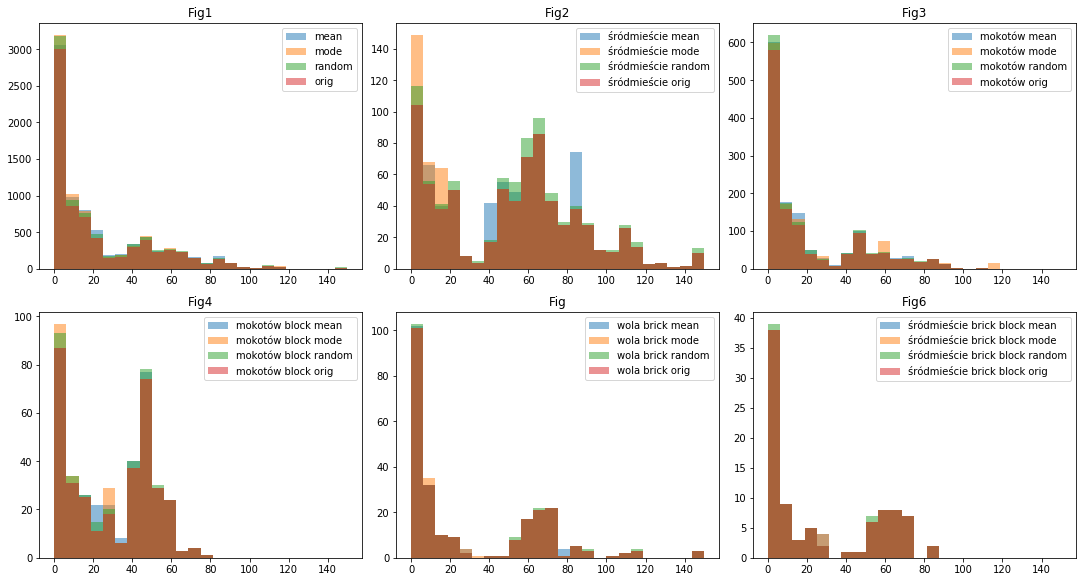

In [25]:
bins = np.linspace(min(sample['age']), max(sample['age']), 25)

f, ((ax11, ax12, ax13),(ax21, ax22, ax23)) = plt.subplots(2,3,figsize=(15,8))

ax11.hist(sample['age_mean'].dropna(), bins, alpha=0.5, label='mean')
ax11.hist(sample['age_mode'].dropna(), bins, alpha=0.5, label='mode')
ax11.hist(sample['age_random'].dropna(), bins, alpha=0.5, label='random')
ax11.hist(sample['age'].dropna(), bins, alpha=0.5, label='orig')
ax11.legend(loc='upper right')
ax11.set_title('Fig1')

ax12.hist(sample[sample['Borough']=='śródmieście']['age_mean'].dropna(), bins, alpha=0.5, label='śródmieście mean')
ax12.hist(sample[sample['Borough']=='śródmieście']['age_mode'].dropna(), bins, alpha=0.5, label='śródmieście mode')
ax12.hist(sample[sample['Borough']=='śródmieście']['age_random'].dropna(), bins, alpha=0.5, label='śródmieście random')
ax12.hist(sample[sample['Borough']=='śródmieście']['age'].dropna(), bins, alpha=0.5, label='śródmieście orig')
ax12.legend(loc='upper right')
ax12.set_title('Fig2')

ax13.hist(sample[sample['Borough']=='mokotów']['age_mean'].dropna(), bins, alpha=0.5, label='mokotów mean')
ax13.hist(sample[sample['Borough']=='mokotów']['age_mode'].dropna(), bins, alpha=0.5, label='mokotów mode')
ax13.hist(sample[sample['Borough']=='mokotów']['age_random'].dropna(), bins, alpha=0.5, label='mokotów random')
ax13.hist(sample[sample['Borough']=='mokotów']['age'].dropna(), bins, alpha=0.5, label='mokotów orig')
ax13.legend(loc='upper right')
ax13.set_title('Fig3')

ax21.hist(sample[(sample['Borough']=='mokotów') & (sample['building_type']=='block')]['age_mean'].dropna(), bins, alpha=0.5, label='mokotów block mean')
ax21.hist(sample[(sample['Borough']=='mokotów') & (sample['building_type']=='block')]['age_mode'].dropna(), bins, alpha=0.5, label='mokotów block mode')
ax21.hist(sample[(sample['Borough']=='mokotów') & (sample['building_type']=='block')]['age_random'].dropna(), bins, alpha=0.5, label='mokotów block random')
ax21.hist(sample[(sample['Borough']=='mokotów') & (sample['building_type']=='block')]['age'].dropna(), bins, alpha=0.5, label='mokotów block orig')
ax21.legend(loc='upper right')
ax21.set_title('Fig4')

ax22.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick')]['age_mean'].dropna(), bins, alpha=0.5, label='wola brick mean')
ax22.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick')]['age_mode'].dropna(), bins, alpha=0.5, label='wola brick mode')
ax22.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick')]['age_random'].dropna(), bins, alpha=0.5, label='wola brick random')
ax22.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick')]['age'].dropna(), bins, alpha=0.5, label='wola brick orig')
ax22.legend(loc='upper right')
ax22.set_title('Fig')

ax23.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick') & (sample['building_type']=='block')]['age_mean'].dropna(), bins, alpha=0.5, label='śródmieście brick block mean')
ax23.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick') & (sample['building_type']=='block')]['age_mode'].dropna(), bins, alpha=0.5, label='śródmieście brick block mode')
ax23.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick') & (sample['building_type']=='block')]['age_random'].dropna(), bins, alpha=0.5, label='śródmieście brick block random')
ax23.hist(sample[(sample['Borough']=='wola') & (sample['building_material']=='brick') & (sample['building_type']=='block')]['age'].dropna(), bins, alpha=0.5, label='śródmieście brick block orig')
ax23.legend(loc='upper right')
ax23.set_title('Fig6')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Assesing the quality of inputation. We see that random picked numbers are best.

Interpreting district column
----------
We try to obtain the name of borough from data kept in *district* column

In [26]:
with open("utils/warszawa_addresses.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
addresses = pd.DataFrame(lst)

In [27]:
district_mapping = dict()
for borough in addresses['Borough'].unique():
    district_mapping[borough.lower()] = borough.lower()
for borough, neighbourhood in zip(addresses['Borough'],addresses['Neighbourhood']):
    district_mapping[neighbourhood.lower()] = borough.lower()   

In [28]:
distric_names = list(sample['district'].unique())
for item in distric_names:
    if not item in district_mapping.keys():
        print(item)

praga-północ
praga-południe
centrum
.
królikarnia
jelonki
praga
imielin
dolny mokotów
górny mokotów
annopol
pola mokotowskie
mariensztat
lewandów
białołęka dworska
nowe górce
metro wilanowska
kąty grodziskie
kawęczyn
nowe bródno
augustów
marymont
stokłosy
przyczółek grochowski
kępa gocławska
kępa tarchomińska
latawiec
nowy służewiec
moczydło
witolin


In [29]:
district_mapping['praga-północ'] = 'praga'
district_mapping['lewandów'] = 'białołęka'
district_mapping['praga-południe'] = 'praga'
district_mapping['centrum'] ='śródmieście'
district_mapping['.'] = 'missing'
district_mapping['królikarnia'] = 'mokotów'
district_mapping['jelonki'] = 'bemowo'
district_mapping['praga'] = 'praga'
district_mapping['imielin'] = 'ursynów'
district_mapping['dolny mokotów'] = 'mokotów'
district_mapping['górny mokotów'] ='mokotów'
district_mapping['annopol'] = 'białołęka'
district_mapping['mariensztat'] = 'śródmieście'
district_mapping['białołęka dworska'] = 'białołęka'
district_mapping['nowe górce'] = 'bemowo'
district_mapping['metro wilanowska'] = 'mokotów'
district_mapping['kąty grodziskie'] = 'białołęka'
district_mapping['pola mokotowskie'] = 'mokotów'
district_mapping['kawęczyn'] = 'rembertów'
district_mapping['nowe bródno'] = 'targówek'
district_mapping['augustów'] = 'białołęka'
district_mapping['marymont'] = 'bielany'
district_mapping['przyczółek grochowski'] = 'praga'
district_mapping['kępa tarchomińska'] = 'białołęka'
district_mapping['latawiec'] = 'śródmieście'
district_mapping['stokłosy'] = 'ursynów'
district_mapping['nowy służewiec'] = 'ursynów'
district_mapping['witolin'] = 'praga'

sample['district'] = sample['district'].map(mapping).fillna(".").astype(str)

Saving data
----------

In [30]:
sample['Id'] = sample.index
with open('data/warszawa.csv', 'w') as f:
    sample.to_csv(f, header=True, na_rep='.', sep=';',encoding='utf-8',index=False)